データの整形＆抽出用コード

In [43]:
import pandas as pd
import datetime
import numpy as np
import os

In [81]:
time_stamp = '20230130_22'
base_path = '/Users/takahiromatsunaga/res2023/bledata'
input_path = os.path.join(base_path, f'ble_timegroup/{time_stamp}/{time_stamp}.csv') 
df_ble = pd.read_csv('/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_nw_detail/ble_nw.csv')

親データ（日時指定）からinput用に整形．混雑度列の付与と不要列カット＆15分間のデータの抽出

In [82]:
# 不要列カットしてcsv更新
# 親データ読み込み
# time_stamp = '20230129_17'
input_path = os.path.join(base_path, f'ble_timegroup/{time_stamp}/{time_stamp}.csv') 
df_parents = pd.read_csv(input_path)

# 不要列排除
df_parents = df_parents.iloc[:, 2:]
df_parents.drop(['num', 'type', 'day', 'hour', 'day_flag'], axis=1, inplace=True)

# 既存列更新
df_parents['ID'] = df_parents['ID'].str.replace('id', '').astype(int)
df_parents['time'] = pd.to_datetime(df_parents['time'])

df_parents.to_csv(input_path)

In [83]:
time_stamp[9:]

'22'

In [84]:
start_time = pd.Timestamp(f'{time_stamp[:8]} {time_stamp[9:]}:30:00+09:00')
print(start_time)

2023-01-30 22:30:00+09:00


In [85]:
# 親データから15分間のデータを取り出す
# 更新済みcsvを読み込む

df_parents = pd.read_csv(input_path)
# df_parents = pd.read_csv('/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/20230130_17/20230130_17.csv')
df_parents['time'] = pd.to_datetime(df_parents['time'])
# time_stamp = '20230129_10'

# Timestampはdatetimeをpandas上でも機能させるように作られたもの ### 4:30-45に来る電車は一本しかない！！！しかも山手線じゃ！！
# start_line = pd.Timestamp('2023-01-30 10:30:00+09:00')
start_line = pd.Timestamp(f'{time_stamp[:8]} {time_stamp[9:]}:30:00+09:00')
cutline = pd.Timestamp(f'{time_stamp[:8]} {time_stamp[9:]}:59:59+09:00') # グリニッジより9時間進んでるので

#print(df.loc[1, 'time'].dtype)
df_quater = df_parents[(df_parents['time'] > start_line) & (df_parents['time'] < cutline)]
df_quater = df_quater.iloc[:, 1:]

#df_quater_path = f'/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/{time_stamp}/{time_stamp}45.csv'
df_quater_path = os.path.join(base_path, f'ble_timegroup/{time_stamp}/{time_stamp}30.csv')
#print(df_quater)
df_quater.to_csv(df_quater_path)

以降はpotentialのところを使えばいい？？？


15分データにtimestepを付与

In [ ]:
# 15分データに18sec間隔でtimestepを与える（timestep列）
# start_line = pd.Timestamp('2023-01-29 17:30:00+09:00')
# time_stamp = '20230130_17'
df_quater_path =  os.path.join(base_path, f'ble_timegroup/{time_stamp}/{time_stamp}30.csv')
df_quater = pd.read_csv(df_quater_path)

# print(df_quater.dtypes) 最初timeはobjectなのでdatetime形式に変換
df_quater['time'] = pd.to_datetime(df_quater['time'])

# timeの昇順でデータを並べ替え
df_quater = df_quater.sort_values('time', ascending=True).reset_index(drop=True)

# time_stepを18秒間隔で付与
seconds  = 20
time_delta = pd.Timedelta(seconds) # df_quater['time'].iloc[0]がstart時刻であることを利用
df_quater['timestep'] = (df_quater['time'] - df_quater['time'].iloc[0]) // time_delta + 1

#new_18sec_path = f'/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/{time_stamp}/{time_stamp}45_18sec.csv'
new_sec_path = os.path.join(base_path, f'ble_timegroup/{time_stamp}/{time_stamp}30_{seconds}sec.csv')
df_quater.to_csv(new_sec_path)
#print(df_quater)

【重要】不要列カット/timestep分割等が済んだ15分間データに対し，個人ごとにデータを分割する操作．ここでしかデータの切り落としはしていない！のでデータクリーニングの全てはこのコードにある

In [ ]:

#new_18sec_path = f'/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/{time_stamp}/{time_stamp}45_18sec.csv'
#new_18sec_path = '/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/20230129_17/20230129_1730_18sec.csv'
#df = pd.read_csv(new_18sec_path)
timelimit = 15
#output_folder = f'/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/{time_stamp}/{time_stamp}45_18sec_endgate_under{timelimit}'
output_folder = os.path.join(base_path, f'ble_timegroup/{time_stamp}/{time_stamp}45_{seconds}sec_end162021_under{timelimit}')
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

# bleの階ごとのlist．工事の前中後で変化するので注意
ble_at_home = [1, 2, 3, 4, 5, 6, 22, 23] # [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 22, 23] 
# post [1, 2, 3, 4, 5, 6, 22, 23]
# ble_at_concourse = [7, 15, 16, 17, 18, 19, 20, 21]  # [7, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21] 
# post [7, 15, 16, 17, 18, 19, 20, 21] 
ble_at_concourse = [15, 16, 20, 21, 7] # 

# 全部の改札をdとして許容する場合
# abs_links = [16, 20, 21, 15, 17, 18, 7] # ややこしいが，これはリンクではなくビーコンのid
# 南改札をdに入れない場合
# abs_links = [15, 16, 20, 21, 7] 
abs_links = [16, 20, 21]
# ここでもっと絞れるのではないか
# ble_at_gate = [(15), 16, 17, 18, 20, 21, ]

grouped = df.groupby('MAC')
df_list = [group.reset_index(drop=True) for name, group in grouped]

original_user = len(df_list)
print(original_user)
count = 0
count1 = 0
count2 = 0
count3 = 0
count4 = 0
count5 = 0
count6 = 0

for group in df_list:
    nts = group['timestep'].nunique()

    if nts >= timelimit+1:
       count1 += 1
       continue

    if nts <= 4:
        count1 += 1
        continue
    
    # if nts >= 36:
    #     count1 += 1
    #     continue
    
    group = group.sort_values(by = 'timestep') # 昇順のはず
    ts_diff = group['timestep'].diff().tolist() # 上手くリスト内包表記で書きたい（forで回さない）
    ts_diff = np.nan_to_num(ts_diff, nan = 0)

    # 観測間隔が少しでも空いてる場合（簡単のため落とす）
    if ts_diff.max() >= 2:
        count2 += 1
        continue

    # そうでなくても，間隔3以上の場所が2箇所以上ある場合
    #count_greater_than_3 = sum(x >= 3 for x in ts_diff)
    #if count_greater_than_3 >= 2:
    #    count2 += 1
    #    continue

    # ホーム階or改札階のいずれかのビーコンでしか観測されなかった場合
    uni_beacons = group['ID'].unique().tolist()
    if all(item in ble_at_concourse for item in uni_beacons) or all(item in ble_at_home for item in uni_beacons):        
        count3 += 1
        continue
        # if (not any(item in uni_beacons for item in ble_at_home)) or (not any(item in uni_beacons for item in ble_at_concourse)):

    #timestepでgrouping
    grouped2 = group.groupby('timestep')
    df_list2 = [group2.reset_index(drop=True) for name, group2 in grouped2]

    # 最初と最後でともにhomeあるいは改札で観測された場合
    ts1 = df_list2[0]
    tslast = df_list2[-1]
    ts1_ble = ts1['ID'].unique()
    tslast_ble = tslast['ID'].unique()

    # 最後のtimestepで最も観測頻度が大きかったビーコンでdを決める
    most_common_did = tslast['ID'].mode()[0]
    if not most_common_did in abs_links:
        count4 += 1
        continue

    # ホーム階＆改札階で観測されてるけど，ODが同じっぽい場合
    if (all(item in ble_at_home for item in ts1_ble) and all(item in ble_at_home for item in tslast_ble)):
        count5 += 1
        continue
    if (all(item in ble_at_concourse for item in ts1_ble) and all(item in ble_at_concourse for item in tslast_ble)):
        count5 += 1
        continue

    # 同時点に6個以上のビーコンで観測された場合（class1だとして落とす）．
    for group2 in df_list2:
        nbeacon = group2['ID'].nunique()
        if nbeacon >= 7:
            count6 += 1
            break

    # 上記の条件を潜り抜けるとここに行き着く
    file_path = os.path.join(output_folder, f'{count}.csv')
    group.to_csv(file_path, index=False)
    count += 1

print(count, count1, count2, count3, count4, count5, count6)

# 前よりはマシなサンプリングができていると思う

84023
1120 60968 15092 2243 4466 134 8


In [ ]:
print(len(os.listdir('/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/20230129_17/20230129_1745_18sec_end162021_under10')))

450


In [ ]:
import os
import shutil

def organize_files(src_directory, files_per_folder):
    # すべてのファイルをリストアップ
    files = [f for f in os.listdir(src_directory) if f.endswith('.csv')]
    
    # ファイルを指定された数ごとに分ける
    total_files = len(files)
    for i in range(0, total_files, files_per_folder):
        # 新しいフォルダの名前を定義（例: folder_1, folder_2, ...）
        folder_name = os.path.join(src_directory, f'folder_{i // files_per_folder + 1}')
        os.makedirs(folder_name, exist_ok=True)
        
        # ファイルを新しいフォルダに移動
        for file in files[i:i + files_per_folder]:
            shutil.move(os.path.join(src_directory, file), folder_name)

# ユーザーが指定するソースディレクトリ（CSVファイルが含まれているフォルダ）
source_directory = '/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/20230129_17/20230129_1730_18sec_end162021_under10'
# フォルダあたりのファイル数を指定
files_per_folder = 112

# 関数を実行
organize_files(source_directory, files_per_folder)
# （実行時間早すぎー）

可視化のためにとりあえずODの傾向を見せる．のでホーム→改札or改札→ホームで，かつ時間制限もなし

In [2]:
### 朝夕で一旦比較する
#df = pd.read_csv('/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/20230130_17/20230130_1745_18sec.csv')

# df = pd.read_csv('/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/20230130_08/20230130_0845_20sec.csv')
df = pd.read_csv(os.path.join(base_path, f'ble_timegroup/{time_stamp}/{time_stamp}45_20sec.csv'))
# output_folder = '/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/20230130_08/20230130_0845_20sec_forvisualization'
output_folder = os.path.join(base_path, f'ble_timegroup/2{time_stamp}/{time_stamp}45_20sec_forvisualization')
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

# bleの階ごとのlist．工事の前中後で変化するので注意
ble_at_home = [1, 2, 3, 4, 5, 6, 22, 23] # [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 22, 23] # post [1, 2, 3, 4, 5, 6, 22, 23]
ble_at_concourse = [7, 15, 16, 17, 18, 19, 20, 21]  # [7, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21] # post [7, 15, 16, 17, 18, 19, 20, 21] 
abs_links = [16, 20, 21]

# ここでもっと絞れるのではないか
# ble_at_gate = [(15), 16, 17, 18, 20, 21, ]

grouped = df.groupby('MAC')
df_list = [group.reset_index(drop=True) for name, group in grouped]

original_user = len(df_list)
print(original_user)
count = 0
count1 = 0
count2 = 0
count3 = 0
count4 = 0
count5 = 0
count6 = 0

for group in df_list:
    nts = group['timestep'].nunique()
    if nts <= 4: # 短すぎるのはカット
        count1 += 1
        continue

    if nts <= 10:
        count1 += 1
        continue
    
    group = group.sort_values(by = 'timestep') # 昇順のはず
    ts_diff = group['timestep'].diff().tolist() # 上手くリスト内包表記で書きたい（forで回さない）
    ts_diff = np.nan_to_num(ts_diff, nan = 0)

    # 観測間隔が少しでも空いてる場合（簡単のため落とす）
    #if ts_diff.max() >= 2:
    #    count2 += 1
    #    continue

    # そうでなくても，間隔3以上の場所が2箇所以上ある場合
    #count_greater_than_3 = sum(x >= 3 for x in ts_diff)
    #if count_greater_than_3 >= 2:
    #    count2 += 1
    #    continue

    # ホーム階or改札階のいずれかのビーコンでしか観測されなかった場合
    uni_beacons = group['ID'].unique().tolist()
    if all(item in ble_at_concourse for item in uni_beacons) or all(item in ble_at_home for item in uni_beacons):        
        count3 += 1
        continue
        # if (not any(item in uni_beacons for item in ble_at_home)) or (not any(item in uni_beacons for item in ble_at_concourse)):

    grouped2 = group.groupby('timestep')
    df_list2 = [group2.reset_index(drop=True) for name, group2 in grouped2]

    ts1 = df_list2[0]
    tslast = df_list2[-1]
    ts1_ble = ts1['ID'].unique()
    tslast_ble = tslast['ID'].unique()

    # 最後の最頻ビーコンが改札かホームでない場合
    most_common_did = tslast['ID'].mode()[0]
    if not ((most_common_did in ble_at_home) or (most_common_did in ble_at_concourse)):
        count4 += 1
        continue

    # 最初の最頻ビーコンが改札かホームでない場合
    most_common_oid = ts1['ID'].mode()[0]
    if not ((most_common_oid in ble_at_home) or (most_common_oid in ble_at_concourse)):
        count4 += 1
        continue

    # ホーム階＆改札階で観測されてるけど，ODが同じっぽい場合
    if (all(item in ble_at_home for item in ts1_ble) and all(item in ble_at_home for item in tslast_ble)):
        count5 += 1
        continue
    if (all(item in ble_at_concourse for item in ts1_ble) and all(item in ble_at_concourse for item in tslast_ble)):
        count5 += 1
        continue


    # 同時点に7個以上のビーコンで観測された場合（class1だとして落とす）．
    for group2 in df_list2:
        nbeacon = group2['ID'].nunique()
        if nbeacon >= 7:
            count6 += 1
            break

    # 上記の条件を潜り抜けるとここに行き着く
    file_path = os.path.join(output_folder, f'{count}.csv')
    group.to_csv(file_path, index=False)
    count += 1

print(count, count1, count2, count3, count4, count5, count6)

# 前よりはマシなサンプリングができていると思う

52199
11501 37203 0 2156 0 1339 199


300サンプルずつ＊10セット（（（nanの意味がある？

In [ ]:
import os 
import shutil

sample_count = 300

# 10個のサンプルフォルダを作成
for i in range(10):
    read_folder = '/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/20230130_08/user_stock_kai'
    file_list = os.listdir(read_folder)
    output_folder = f"/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/20230130_08/stock_kai300_{i}"

    if not os.path.exists(output_folder):
        os.mkdir(output_folder)

    # 最初のn個のCSVファイルをコピー
    count = 0
    for file in file_list:
        if file.endswith(".csv"):
            source_file = os.path.join(read_folder, file)
            destination_file = os.path.join(output_folder, file)
            shutil.copy(source_file, destination_file)
            count += 1
            if count == sample_count:
                break

    print(f"{count}個のCSVファイルを新しいフォルダに複製しました。")

基礎集計（今更何してんの）

In [2]:
# 最初と最後のbleを見てみる
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os 

read_folder = '/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/20230130_08/stock500'
file_list = list(os.listdir(read_folder))

od = []

for file_name in file_list:
    file_path = os.path.join(read_folder, file_name)
    df = pd.read_csv(file_path)

    first_ble = df.loc[0, 'ID']
    last_ble = df.iloc[-1]['ID']

    tuple = (first_ble, last_ble)

    od.append(tuple)

print(od)

[(19, 23), (16, 6), (6, 18), (19, 1), (16, 1), (20, 22), (18, 1), (20, 23), (5, 6), (15, 23), (23, 17), (5, 21), (4, 15), (16, 3), (20, 23), (20, 6), (21, 6), (5, 21), (16, 2), (16, 4), (22, 20), (15, 2), (1, 19), (20, 4), (22, 18), (16, 2), (20, 5), (16, 23), (1, 15), (5, 21), (2, 16), (6, 20), (20, 5), (6, 20), (20, 4), (3, 20), (16, 22), (20, 1), (20, 4), (1, 17), (2, 16), (16, 2), (2, 16), (17, 2), (2, 7), (2, 15), (22, 20), (16, 1), (6, 7), (15, 16), (20, 6), (20, 5), (22, 18), (5, 15), (20, 6), (2, 16), (16, 22), (19, 22), (17, 3), (20, 19), (20, 6), (4, 18), (4, 16), (7, 1), (17, 22), (3, 7), (2, 16), (4, 18), (20, 6), (2, 18), (4, 7), (5, 21), (16, 23), (21, 23), (20, 6), (15, 2), (4, 15), (7, 22), (15, 2), (18, 23), (20, 5), (4, 21), (5, 20), (20, 5), (20, 6), (17, 2), (19, 22), (16, 22), (20, 6), (23, 7), (20, 6), (20, 6), (23, 21), (1, 7), (20, 19), (2, 16), (4, 23), (4, 21), (17, 22), (2, 16), (7, 22), (20, 6), (22, 16), (4, 18), (19, 1), (4, 16), (4, 15), (16, 3), (1, 16),

In [6]:
# dfからそのままcrosstable関数で黒須集計がすぐにできるらしい
od_df = pd.DataFrame(od, columns=['o', 'd'])

cross_table = pd.crosstab(od_df['o'], od_df['d'], margins=True, margins_name='total')
print(cross_table)

# やや南改札が少ないか．1分以上かかるのかな．
# 欠損を結構省いているが，接続行列出して尤度計算する時がわの処理が良くない説がある．
# 正規化して前の確率を補正したほうがいいかも

d       1   2   3   4   5   6   7  15  16  17  18  19  20  21  22  23  total
o                                                                           
1       0   0   0   0   0   0   9   3   8   5   0   2   4   5   0   2     38
2       0   0   0   0   0   0   2  13  28   0   3   0   1   2   0   0     49
3       0   0   0   0   0   0   5   2   0   4   6   1   2   4   1   0     25
4       0   1   1   0   0   0   4   5   7   2   5   1   4   5   1   2     38
5       0   1   0   0   0   1   1   3   3   0   1   1   5   7   0   2     25
6       1   1   0   0   0   1   1   0   0   0   2   0   9   8   0   0     23
7       5   1   1   0   0   4   0   1   0   0   1   0   0   1   4   0     18
15      0   4   1   0   0   0   0   0   1   0   0   0   0   1   2   3     12
16      6  17   4   3   0   1   1   0   1   0   0   0   1   0   9   6     49
17      4   5   2   4   0   0   0   0   0   0   0   0   0   0   8   5     28
18      2   2   3   0   1   1   0   0   0   1   0   0   0   0   1   3     14

d   1   2   3   4   5   6   7   15  16  17  18  19  20  21  22  23
o                                                                 
1    0   0   0   0   0   0   9   3   8   5   0   2   4   5   0   2
2    0   0   0   0   0   0   2  13  28   0   3   0   1   2   0   0
3    0   0   0   0   0   0   5   2   0   4   6   1   2   4   1   0
4    0   1   1   0   0   0   4   5   7   2   5   1   4   5   1   2
5    0   1   0   0   0   1   1   3   3   0   1   1   5   7   0   2
6    1   1   0   0   0   1   1   0   0   0   2   0   9   8   0   0
7    5   1   1   0   0   4   0   1   0   0   1   0   0   1   4   0
15   0   4   1   0   0   0   0   0   1   0   0   0   0   1   2   3
16   6  17   4   3   0   1   1   0   1   0   0   0   1   0   9   6
17   4   5   2   4   0   0   0   0   0   0   0   0   0   0   8   5
18   2   2   3   0   1   1   0   0   0   1   0   0   0   0   1   3
19   3   0   0   0   0   0   0   0   0   0   0   1   1   0   5   2
20   6   1   5   9  13  48   1   0   0   1   0   2   1   0   2

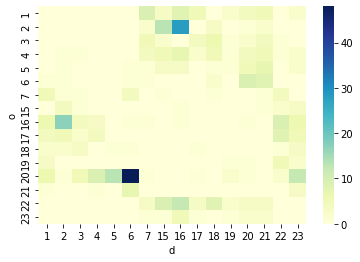

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
od_df = pd.DataFrame(od, columns=['o', 'd'])

cross_table = pd.crosstab(od_df['o'], od_df['d']) #, margins=True, margins_name='total')
print(cross_table)
sns.heatmap(cross_table, annot=False, fmt="d", cmap="YlGnBu")
plt.show()

In [15]:
# 最初と最後のbleを見てみる
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os 

read_folder = '/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/20221218_17/stock500'
file_list = list(os.listdir(read_folder))

od = []

for file_name in file_list:
    file_path = os.path.join(read_folder, file_name)
    df = pd.read_csv(file_path)

    first_ble = df.loc[0, 'ID']
    last_ble = df.iloc[-1]['ID']

    tuple = (first_ble, last_ble)

    od.append(tuple)

print(od)

[(8, 13), (19, 11), (18, 22), (15, 8), (18, 23), (20, 10), (6, 21), (6, 21), (21, 2), (7, 3), (22, 15), (1, 12), (4, 15), (19, 6), (18, 23), (15, 10), (4, 15), (1, 21), (23, 19), (21, 11), (19, 11), (20, 20), (4, 21), (6, 7), (21, 11), (15, 2), (22, 15), (13, 10), (20, 20), (4, 23), (17, 22), (20, 5), (20, 6), (7, 5), (5, 15), (20, 10), (4, 7), (3, 7), (6, 23), (22, 18), (1, 21), (15, 10), (19, 22), (22, 15), (15, 23), (21, 6), (7, 6), (1, 20), (15, 22), (21, 11), (4, 15), (21, 10), (11, 11), (11, 21), (3, 21), (21, 10), (20, 22), (21, 11), (22, 15), (20, 23), (1, 15), (20, 22), (21, 11), (20, 6), (18, 23), (4, 17), (5, 10), (2, 15), (20, 6), (2, 18), (6, 23), (12, 10), (18, 22), (20, 6), (2, 4), (1, 20), (20, 6), (13, 11), (1, 15), (22, 18), (4, 3), (7, 11), (1, 15), (21, 10), (15, 13), (23, 20), (21, 23), (20, 6), (19, 6), (6, 21), (20, 11), (2, 10), (15, 8), (18, 3), (2, 15), (20, 11), (1, 21), (4, 23), (3, 15), (2, 15), (20, 11), (17, 1), (22, 23), (18, 3), (20, 10), (21, 6), (5, 2

In [17]:
# dfからそのままcrosstable関数で黒須集計がすぐにできるらしい
od_df = pd.DataFrame(od, columns=['o', 'd'])

cross_table = pd.crosstab(od_df['o'], od_df['d'], margins=True, margins_name='total')
print(cross_table)

d       1   2   3   4  5   6   7   8  10  11  ...  14  15  17  18  19  20  21  \
o                                             ...                               
1       0   0   0   0  0   0   5   0   1   0  ...   0  15   0   0   0   2  13   
2       1   1   0   1  0   0   0   0   1   0  ...   1  12   0   1   1   3   4   
3       0   0   1   0  0   0   1   0   0   0  ...   3   8   0   1   0   0   6   
4       0   0   1   2  0   0   3   1   2   1  ...   1   7   1   0   2   4  12   
5       0   0   1   1  0   0   1   0   3   2  ...   0   4   0   0   0   1   7   
6       1   0   1   0  0   1   3   0   1   0  ...   0   5   0   0   2   1   6   
7       2   1   1   1  1   5   0   0   3   6  ...   0   1   0   0   0   0   0   
8       0   0   0   0  0   0   1   0   0   0  ...   0   2   1   0   0   0   0   
11      0   0   0   0  0   0   1   0   1   1  ...   0   0   0   0   2   7   4   
12      0   0   0   0  0   0   0   0   3   0  ...   0   1   0   0   0   0   0   
13      0   0   1   0  1   0

d   1   2   3   4   5   6   7   8   10  11  ...  13  14  15  17  18  19  20  \
o                                           ...                               
1    0   0   0   0   0   0   5   0   1   0  ...   2   0  15   0   0   0   2   
2    1   1   0   1   0   0   0   0   1   0  ...   1   1  12   0   1   1   3   
3    0   0   1   0   0   0   1   0   0   0  ...   0   3   8   0   1   0   0   
4    0   0   1   2   0   0   3   1   2   1  ...   0   1   7   1   0   2   4   
5    0   0   1   1   0   0   1   0   3   2  ...   0   0   4   0   0   0   1   
6    1   0   1   0   0   1   3   0   1   0  ...   0   0   5   0   0   2   1   
7    2   1   1   1   1   5   0   0   3   6  ...   1   0   1   0   0   0   0   
8    0   0   0   0   0   0   1   0   0   0  ...   1   0   2   1   0   0   0   
11   0   0   0   0   0   0   1   0   1   1  ...   0   0   0   0   0   2   7   
12   0   0   0   0   0   0   0   0   3   0  ...   0   0   1   0   0   0   0   
13   0   0   1   0   1   0   0   0   2   3  ...   0 

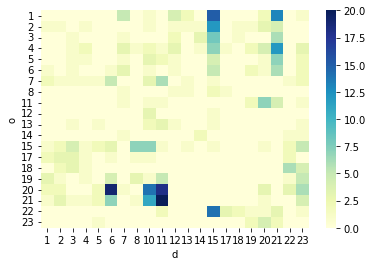

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
od_df = pd.DataFrame(od, columns=['o', 'd'])

cross_table = pd.crosstab(od_df['o'], od_df['d']) #, margins=True, margins_name='total')
print(cross_table)
sns.heatmap(cross_table, annot=False, fmt="d", cmap="YlGnBu")
plt.show()